In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn import metrics
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
import os, datetime, sys, random, time
import seaborn as sns
import xgboost as xgs
import lightgbm as lgb
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('fivethirtyeight')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import time
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
Data = pd.read_csv('cs-training.csv')

## Data dictionary

**SeriousDlqin2yrs** Person experienced 90 days past due delinquency or worse

**RevolvingUtilizationOfUnsecuredLines**: Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits

**age**	Age of borrower in years

**NumberOfTime30-59DaysPastDueNotWorse**: Number of times borrower has been 30-59 days past due but no worse in the last 2 years.

**DebtRatio**: Monthly debt payments, alimony,living costs divided by monthy gross income

**MonthlyIncome**: Monthly income

**NumberOfOpenCreditLinesAndLoans**: Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)

**NumberOfTimes90DaysLate**: Number of times borrower has been 90 days or more past due.

**NumberRealEstateLoansOrLines**: Number of mortgage and real estate loans including home equity lines of credit

**NumberOfTime60-89DaysPastDueNotWorse**: Number of times borrower has been 60-89 days past due but no worse in the last 2 years.

**NumberOfDependents**: Number of dependents in family excluding themselves (spouse, children etc.)

## Data Preprocessing

In [3]:
# Age Outlier Removal

filteredData = Data[Data.age<99]
filteredData = filteredData[Data.age>=20]

In [4]:
#New Features
filteredData['missingNumberOfDependents'] = np.where(pd.isnull(filteredData['NumberOfDependents']),1,0)
filteredData['NumberOfDependents'].fillna(0,inplace=True)

filteredData['missingMonthlyIncome'] = np.where(filteredData['MonthlyIncome']>0,0,1)
filteredData['MonthlyIncome'].fillna(0,inplace=True)

filteredData['MonthlyIncomePerPerson'] = filteredData['MonthlyIncome']/(filteredData['NumberOfDependents']+1)
# filteredData['MonthlyIncomePerPerson'].fillna(0, inplace=True)

filteredData['MonthlyDebt'] = filteredData['MonthlyIncome']*filteredData['DebtRatio']
# filteredData['MonthlyDebt'].fillna(filteredData['DebtRatio'],inplace=True)
filteredData['MonthlyDebt'] = np.where(filteredData['MonthlyDebt']==0,
                                       filteredData['DebtRatio'],
                                       filteredData['MonthlyDebt'])

filteredData['isRetired'] = np.where((filteredData['age'] > 65), 1, 0)

filteredData['RevolvingLines'] = filteredData['NumberOfOpenCreditLinesAndLoans']-filteredData['NumberRealEstateLoansOrLines']

filteredData['hasRevolvingLines']=np.where((filteredData['RevolvingLines']>0),1,0)

filteredData['hasMultipleRealEstates'] = np.where((filteredData['NumberRealEstateLoansOrLines']>=2),1,0)

# Set those 96/98 values to 0 after creating a special column to indicate such special values
filteredData['didNotDeclareTimesLate'] = np.where((filteredData['NumberOfTime30-59DaysPastDueNotWorse']>=90),1,0)
filteredData[filteredData['NumberOfTime30-59DaysPastDueNotWorse']>=90]=0
filteredData[filteredData['NumberOfTime60-89DaysPastDueNotWorse']>=90]=0
filteredData[filteredData['NumberOfTimes90DaysLate']>=90]=0

filteredData['incomeDivByThousand'] = np.where((filteredData['MonthlyIncome']%1000==0),1,0)

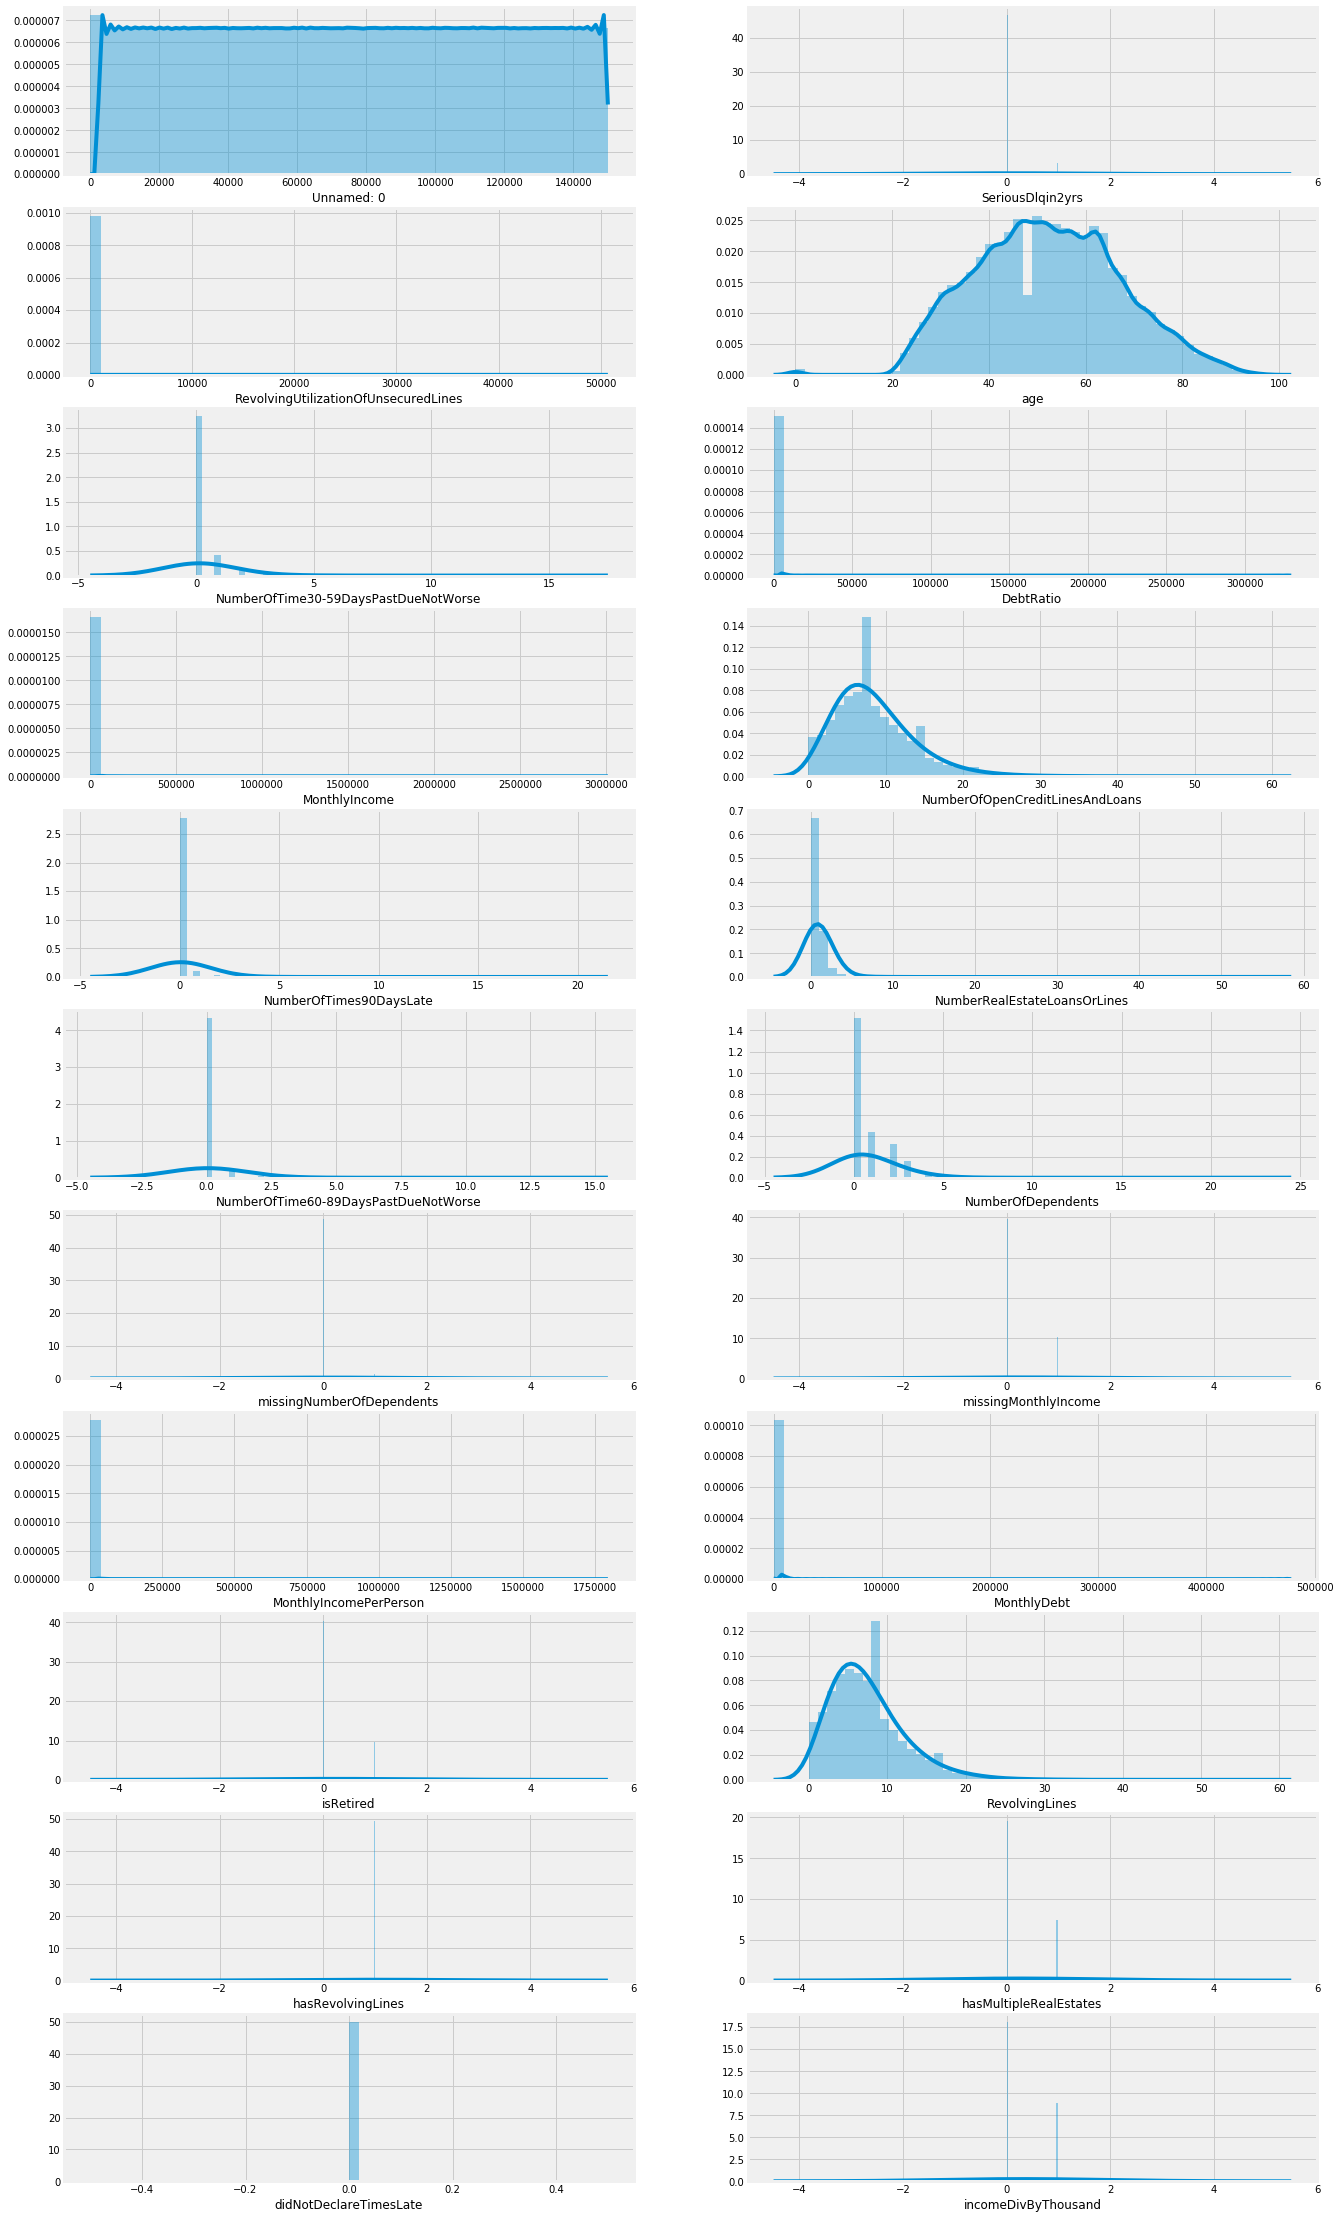

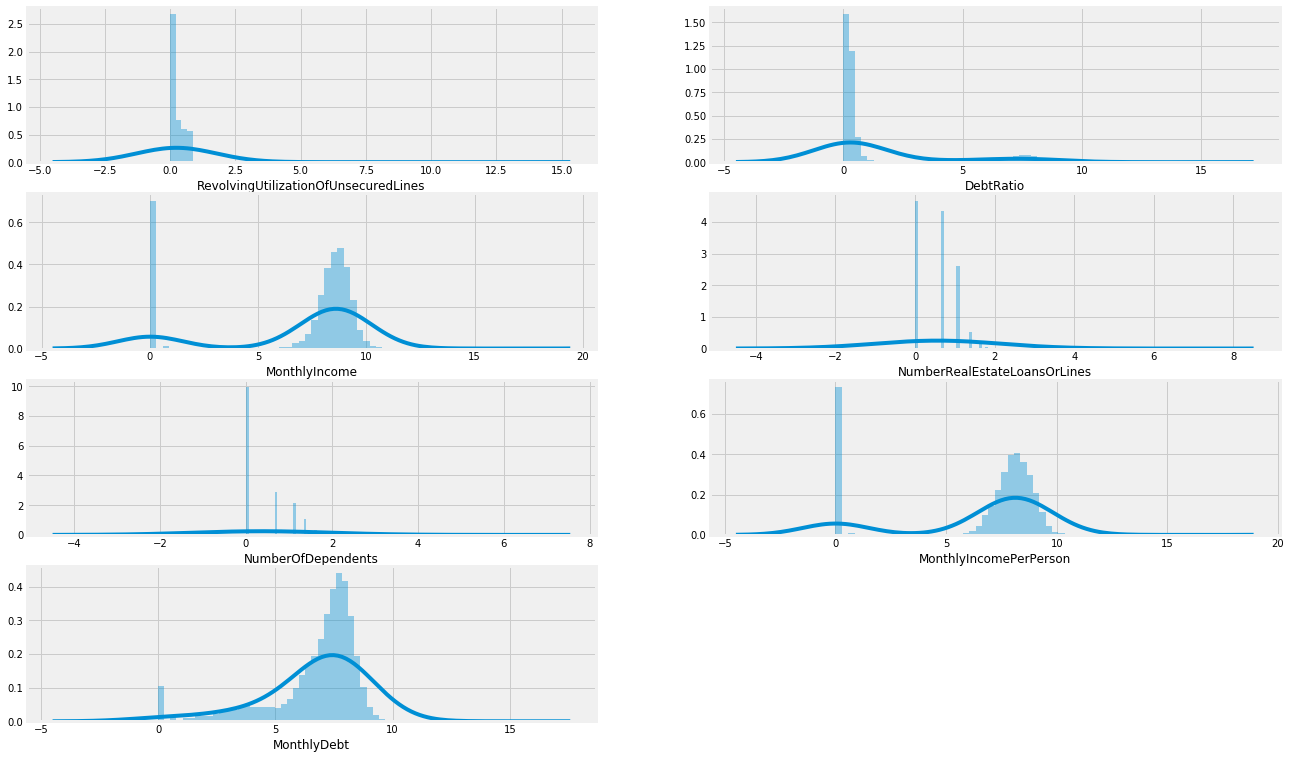

In [5]:
# Data transformation
columnList = list(filteredData.columns)

fig = plt.figure(figsize=[20,40])
for col,i in zip(columnList,range(1,len(columnList)+1)):
    axes = fig.add_subplot(round(len(columnList)/2),2,i)
    sns.distplot(filteredData[col],ax=axes, kde_kws={'bw':1.5})
plt.show()

columnListUpdated = list(filteredData.columns.values[[2,5,6,9,11,14,15]])
columnListUpdated

fig = plt.figure(figsize=[20,20])
for col,i in zip(columnListUpdated,range(1,13)):
    filteredData[col]=np.log(1+filteredData[col].values)
    axes = fig.add_subplot(6,2,i)
    sns.distplot(filteredData[col],ax=axes, kde_kws={'bw':1.5})
plt.show()

# Support Vector Machine

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

In [8]:
filteredDataCl = filteredData.drop(['Unnamed: 0'],1)

# Data split into training and test set
xData_svm = filteredDataCl.drop('SeriousDlqin2yrs', axis=1)
yData_svm = filteredDataCl['SeriousDlqin2yrs']

xTrain_svm, xTest_svm, yTrain_svm, yTest_svm = train_test_split(xData_svm, yData_svm, test_size = 0.25,random_state=2020)

print('xSVM_train shape:', xTrain_svm.shape)
print('xSVM_test shape:', xTest_svm.shape)

print(yData_svm[yData_svm==1].count())
print(yData_svm[yData_svm==0].count())
print('Imbalanced 1 and 0 ratio:', yData_svm[yData_svm==1].count()/yData_svm[yData_svm==0].count())

xSVM_train shape: (112482, 20)
xSVM_test shape: (37495, 20)
9876
140101
Imbalanced 1 and 0 ratio: 0.070492002198414


In [9]:
# Standard Scaler

cols = xTrain_svm.columns
scaler = StandardScaler()
xTrain_svm_ss = scaler.fit_transform(xTrain_svm)
xTest_svm_ss = scaler.transform(xTest_svm)
xTrain_svm_ss = pd.DataFrame(xTrain_svm_ss, columns = [cols])
xTest_svm_ss = pd.DataFrame(xTest_svm_ss, columns = [cols])

### Randomized Search

In [10]:
from sklearn.metrics import fbeta_score, make_scorer

ftwo_scorer=metrics.make_scorer(metrics.fbeta_score, beta=2)
param_grid_svm = {
    'kernel' : ['rbf', 'poly', 'linear'],
    'C' : [1, 100], 
    'max_iter' : [100000],
    'class_weight' : [None,'balanced']
}

grid_svm=model_selection.RandomizedSearchCV(SVC(), param_grid_svm, cv=10, scoring = ftwo_scorer)
grid_svm.fit(xTrain_svm_ss, yTrain_svm)

In [11]:
%%time
grid_svm=model_selection.RandomizedSearchCV(SVC(), param_grid_svm, cv=10, scoring = ftwo_scorer)
grid_svm.fit(xTrain_svm_ss, yTrain_svm)

Wall time: 10h 18min 59s


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=None,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'C': [1, 100],
                                        'class_weight': [None, 'balanced'],
                                        'kernel': ['rbf', 'poly', 'linear'],
                                        'max_iter': [100000]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False,
                   scoring=make_scorer(fbeta_score, beta=2), verbose=0)

In [12]:
Best_svc=grid_svm.best_estimator_
grid_svm.best_params_

{'max_iter': 100000, 'kernel': 'rbf', 'class_weight': 'balanced', 'C': 1}

              precision    recall  f1-score   support

           0       0.98      0.82      0.89     35035
           1       0.23      0.76      0.35      2460

    accuracy                           0.82     37495
   macro avg       0.60      0.79      0.62     37495
weighted avg       0.93      0.82      0.86     37495

F2 Score: 0.5182757471392068
Test AUC is: 0.850342932328995
Average precision-recall score: 0.28
confusion matrix
[[28739  6296]
 [  594  1866]]


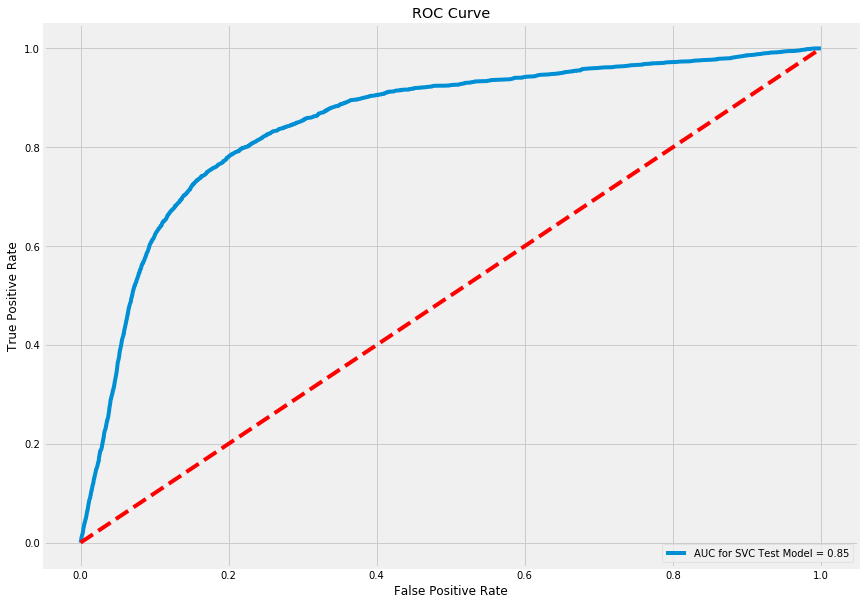

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.28')

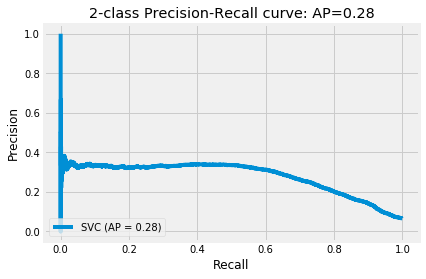

In [13]:
# Estimate y by test set
yTestPred_Best = Best_svc.predict(xTest_svm_ss)
print(metrics.classification_report(yTest_svm,yTestPred_Best))
print('F2 Score:',metrics.fbeta_score(yTest_svm,yTestPred_Best,beta=2))

yTestScore_Best = Best_svc.decision_function(xTest_svm_ss)
fpr,tpr,thres = metrics.roc_curve(yTest_svm,yTestScore_Best)
BestTest_rocAuc = metrics.auc(fpr, tpr)
print('Test AUC is:', BestTest_rocAuc)

BestTest_precision = average_precision_score(yTest_svm, yTestScore_Best)
print('Average precision-recall score: {0:0.2f}'.format(
      BestTest_precision))

print('confusion matrix')
print(metrics.confusion_matrix(yTest_svm,yTestPred_Best))

#Plot ROC
plt.figure(figsize=(13,10))
plt.title('ROC Curve')
sns.lineplot(fpr, tpr, label = 'AUC for SVC Test Model = %0.2f' % BestTest_rocAuc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Plot Precision_Recall Curve
disp_Best = plot_precision_recall_curve(Best_svc, xTest_svm_ss, yTest_svm)
disp_Best.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(BestTest_precision))

### SVM with rbf kernel, c=1 and class=balanced

In [14]:
%%time
rbf1_svc = SVC(gamma='scale', class_weight='balanced')
rbf1_svc.fit(xTrain_svm_ss, yTrain_svm)

print('Accuracy of classifier on training set: {:.2f}'.format(rbf1_svc.score(xTrain_svm_ss, yTrain_svm) * 100))
print('Accuracy of classifier on test set: {:.2f}'.format(rbf1_svc.score(xTest_svm_ss, yTest_svm) * 100))

Accuracy of classifier on training set: 81.63
Accuracy of classifier on test set: 81.64
Wall time: 15min 46s


              precision    recall  f1-score   support

           0       0.98      0.82      0.89     35035
           1       0.23      0.76      0.35      2460

    accuracy                           0.82     37495
   macro avg       0.60      0.79      0.62     37495
weighted avg       0.93      0.82      0.86     37495

F2 Score: 0.5184197366227705
Test AUC is: 0.8503026009994652
Average precision-recall score: 0.28
confusion matrix
[[28744  6291]
 [  594  1866]]


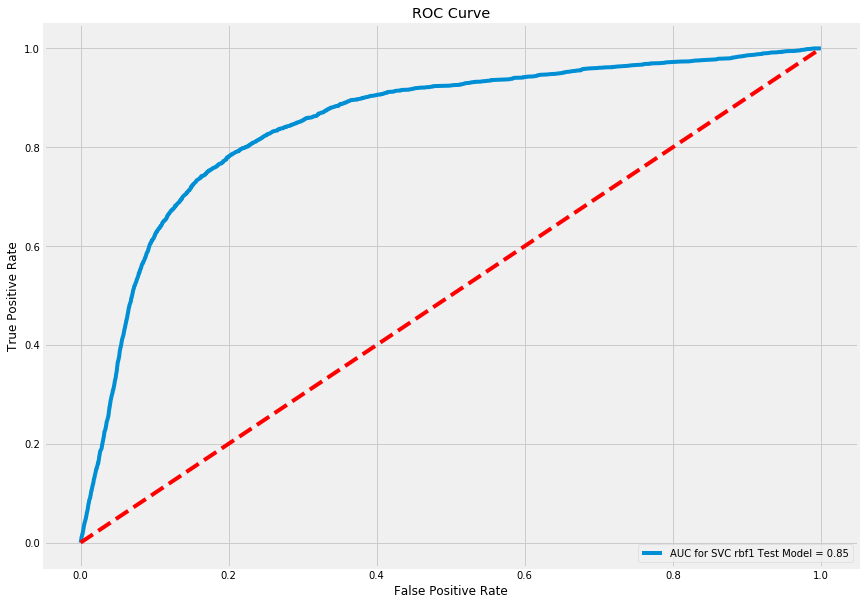

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.28')

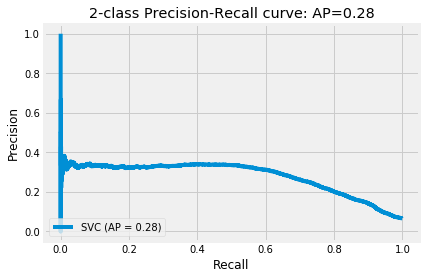

In [15]:
# Estimate y by test set
yTestPred_rbf1 = rbf1_svc.predict(xTest_svm_ss)
print(metrics.classification_report(yTest_svm,yTestPred_rbf1))
print('F2 Score:',metrics.fbeta_score(yTest_svm,yTestPred_rbf1,beta=2))

yTestScore_rbf1 = rbf1_svc.decision_function(xTest_svm_ss)
fpr,tpr,thres = metrics.roc_curve(yTest_svm,yTestScore_rbf1)
rbf1Test_rocAuc = metrics.auc(fpr, tpr)
print('Test AUC is:', rbf1Test_rocAuc)

rbf1Test_precision = average_precision_score(yTest_svm, yTestScore_rbf1)
print('Average precision-recall score: {0:0.2f}'.format(
      rbf1Test_precision))

print('confusion matrix')
print(metrics.confusion_matrix(yTest_svm,yTestPred_rbf1))

#Plot ROC
plt.figure(figsize=(13,10))
plt.title('ROC Curve')
sns.lineplot(fpr, tpr, label = 'AUC for SVC rbf1 Test Model = %0.2f' % rbf1Test_rocAuc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Plot Precision_Recall Curve
disp_rbf1 = plot_precision_recall_curve(rbf1_svc, xTest_svm_ss, yTest_svm)
disp_rbf1.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(rbf1Test_precision))